## RLlib continued

In [38]:
# HIDDEN
import gym
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 16
from ray import rllib
from ray.rllib.algorithms.ppo import PPO, PPOConfig

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#### RLlib features

- So far we've seen training, evaluation, and "prediction" with RLlib.
- Next we'll explore a few more features:
   - Algorithm configs
   - Saving/restoring models
   - Interpreting stochastic policies

#### Algorithm configs

Remember this code?

```python
from ray.rllib.algorithms.ppo import PPO, PPOConfig
ppo = PPO(env="FrozenLake-v1", config=ppo_config)
```

Previously, we hid the `ppo_config`. Now we'll delve into it.

In [6]:
ppo_config = PPOConfig()

The number of options is way too many to read:

In [20]:
len(ppo_config.to_dict())

125

In [21]:
ppo_config.to_dict()

{'extra_python_environs_for_driver': {},
 'extra_python_environs_for_worker': {},
 'num_gpus': 0,
 'num_cpus_per_worker': 1,
 'num_gpus_per_worker': 0,
 '_fake_gpus': False,
 'custom_resources_per_worker': {},
 'placement_strategy': 'PACK',
 'eager_tracing': False,
 'eager_max_retraces': 20,
 'tf_session_args': {'intra_op_parallelism_threads': 2,
  'inter_op_parallelism_threads': 2,
  'gpu_options': {'allow_growth': True},
  'log_device_placement': False,
  'device_count': {'CPU': 1},
  'allow_soft_placement': True},
 'local_tf_session_args': {'intra_op_parallelism_threads': 8,
  'inter_op_parallelism_threads': 8},
 'env': None,
 'env_config': {'is_slippery': False},
 'observation_space': None,
 'action_space': None,
 'env_task_fn': None,
 'render_env': False,
 'clip_rewards': None,
 'normalize_actions': True,
 'clip_actions': False,
 'disable_env_checking': False,
 'num_workers': 2,
 'num_envs_per_worker': 1,
 'sample_collector': ray.rllib.evaluation.collectors.simple_list_collector.S

#### Algorithm configs

- When we instantiate a `PPOConfig()` we get the default config values.
- There are a few values that we changed:

In [11]:
ppo_config = ppo_config.framework("torch")

⬆️ Changes the framework from tensorflow (default) to pytorch.

In [13]:
ppo_config = ppo_config.debugging(seed=0, log_level="ERROR")

⬆️ Sets a random seed for reproducibility of the course, reduces the warnings displayed.

In [15]:
ppo_config = ppo_config.training(model={"fcnet_hiddens" : [32, 32]})

⬆️ Sets the policy neural network to have a smaller-than-default architecture, which helps the course materials run faster.

In [16]:
ppo_config = ppo_config.rollouts(create_env_on_local_worker=True)

⬆️ This relates to Ray, which we will touch on briefly in Module 5, but skip for now.

In [17]:
ppo_config = ppo_config.environment(env_config={"is_slippery" : False})

⬆️ This is how we set env parameters, in this case specifying the non-slippery Frozen Lake.

Notes:

The random seed is only for the algorithm itself, e.g. randomness in the neural network optimization. It doesn't set the random seed for the environment's own randomness. 

#### Algorithm configs

We can also generate this config in one giant line of Python as follows:

In [19]:
ppo_config = (
    PPOConfig()\
    .framework("torch")\
    .rollouts(create_env_on_local_worker=True)\
    .debugging(seed=0, log_level="ERROR")\
    .training(model={"fcnet_hiddens" : [32, 32]})\
    .environment(env_config={"is_slippery" : False})
)

(The `\` character just means the line of Python continues below.)

Notes:

We'll discuss tuning in Module 5.

In [ ]:
# HIDDEN
algo_config = (
    PPOConfig()\
    .framework("torch")\
    .rollouts(create_env_on_local_worker=True)\
    .debugging(seed=0, log_level="ERROR")\
    .training(model={"fcnet_hiddens" : [32, 32]})\
    .environment(env_config={"is_slippery" : False})
)

#### Building an algorithm from the config

We previously instantiated our PPO algorithm like this:

In [24]:
ppo = PPO(env="FrozenLake-v1", config=ppo_config)

(RolloutWorker pid=22500) /Users/mike/git/anyscale/ray/python/ray/rllib/utils/debug/deterministic.py:42: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
(RolloutWorker pid=22500)   if LooseVersion(torch.__version__) >= LooseVersion("1.8.0"):
(RolloutWorker pid=22499) /Users/mike/git/anyscale/ray/python/ray/rllib/utils/debug/deterministic.py:42: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
(RolloutWorker pid=22499)   if LooseVersion(torch.__version__) >= LooseVersion("1.8.0"):
(RolloutWorker pid=22500) /Users/mike/miniconda3/envs/ray2beta/lib/python3.9/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
(RolloutWorker pid=22500)   deprecation(
(RolloutWorker pid=22500) /Users/mike/miniconda3/envs/ray2beta/

The preferred syntax in the latest release of Ray/RLlib is:

In [25]:
ppo = ppo_config.build(env="FrozenLake-v1")

(RolloutWorker pid=22649) /Users/mike/git/anyscale/ray/python/ray/rllib/utils/debug/deterministic.py:42: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
(RolloutWorker pid=22649)   if LooseVersion(torch.__version__) >= LooseVersion("1.8.0"):
(RolloutWorker pid=22649) /Users/mike/miniconda3/envs/ray2beta/lib/python3.9/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
(RolloutWorker pid=22649)   deprecation(
(RolloutWorker pid=22649) /Users/mike/miniconda3/envs/ray2beta/lib/python3.9/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future

As a third option, you can also specify the environment in the config rather than as an argument to `build`:

In [39]:
ppo_config.environment(env="FrozenLake-v1")

ppo = ppo_config.build()

(RolloutWorker pid=8200) /Users/mike/git/anyscale/ray/python/ray/rllib/utils/debug/deterministic.py:42: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
(RolloutWorker pid=8200)   if LooseVersion(torch.__version__) >= LooseVersion("1.8.0"):
(RolloutWorker pid=8200) /Users/mike/miniconda3/envs/ray2beta/lib/python3.9/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
(RolloutWorker pid=8200)   deprecation(
(RolloutWorker pid=8200) /Users/mike/miniconda3/envs/ray2beta/lib/python3.9/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
(Ro

The end result is the same whichever way you choose.

#### Saving models

- We may want to save trained agents for future use.
- This is also called _checkpointing_, especially when done during a training loop.
- In RLlib, this can be done simply with:

```python
algo.save(path_to_checkpoint)
```

It can then be later restored with

```python
algo.restore(path_to_checkpoint)
```

Just make sure you create the trainer with the same environment and parameters when restoring from a checkpoint.

#### Restoring models

- Let's restore a PPO algorithm object
- We need to set it up with the same config first:

In [31]:
ppo_config = (
    PPOConfig()\
    .framework("torch")\
    .rollouts(create_env_on_local_worker=True)\
    .debugging(seed=0, log_level="ERROR")\
    .training(model={"fcnet_hiddens" : [64,64]})
    .environment(env_config={"is_slippery" : True})\
    .evaluation(evaluation_config = {"explore" : False})
)

ppo = ppo_config.build("FrozenLake-v1")

(RolloutWorker pid=32621) /Users/mike/git/anyscale/ray/python/ray/rllib/utils/debug/deterministic.py:42: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
(RolloutWorker pid=32621)   if LooseVersion(torch.__version__) >= LooseVersion("1.8.0"):
(RolloutWorker pid=32621) /Users/mike/miniconda3/envs/ray2beta/lib/python3.9/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
(RolloutWorker pid=32621)   deprecation(
(RolloutWorker pid=32621) /Users/mike/miniconda3/envs/ray2beta/lib/python3.9/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future

In [34]:
ppo.restore("models/FrozenLakeSlippery-256-Ray2/checkpoint-50")

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

Notes:

Apparently, it was trained for 30 iterations, 124k time steps, 1 minute, 17k episodes.

#### Viewing stochastic policies

- If we want to see what a policy does, we can use `compute_single action`
- But, some RL algorithms, including PPO, learn _stochastic policies_.
- We may wish to look at these _action probabilities_.
- The code can be viewed on GitHub, but is hidden here:

In [35]:
from utils import query_policy

In [36]:
env = gym.make("FrozenLake-v1")

We'll use the trainer we just restored:

In [37]:
query_policy(ppo, env, obs=0)

array([0.2502399 , 0.2493437 , 0.25035876, 0.25005776], dtype=float32)

Arena:

```
SFFF
FHFH
FFFH
HFFG
```

Actions: left (0), down (1), right (2), up (3).

Notes:
    
What we see here are the action probabilities. From the top-left, the agent considers moving left down or right, but not up. It's not entirely clear why left is preferred to up.

In module 5 we'll see an RL algorithm that acts deterministically.

For a continuous action space this would be different.

#### Viewing stochastic policies

Let's view all the probabilities:

In [11]:
# HIDDEN
import pandas as pd

In [26]:
action_probs = {obs : query_policy(ppo, env, obs) for obs in range(16)}
pd.DataFrame(action_probs, index=["left", "down", "right", "up"]).T

,left,down,right,up
0,0.361283,0.304118,0.294776,0.039823
1,0.105703,0.295750,0.179304,0.419243
2,0.878681,0.029604,0.040693,0.051021
3,0.436856,0.262808,0.236151,0.064186
4,0.609650,0.186226,0.176718,0.027406
5,0.430741,0.223148,0.239431,0.106680
6,0.021220,0.542077,0.414277,0.022427
7,0.377155,0.222003,0.223822,0.177020
8,0.016745,0.560293,0.378151,0.044812
9,0.007635,0.627997,0.344637,0.019731


#### Viewing stochastic policies

We can also view this as an image:

In [27]:
# HIDDEN
df = pd.DataFrame(action_probs, index=["left", "down", "right", "up"]).T

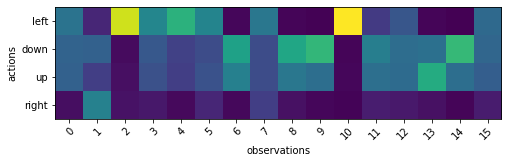

In [97]:
plt.figure(figsize=(8,4))
plt.imshow(df.values.T);
plt.yticks(np.arange(4), labels=["left", "down", "up", "right"]);
plt.xticks(np.arange(16), labels=np.arange(16));
plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor");
plt.xlabel("observations");
plt.ylabel("actions");

Notes:
    
This is transposed to fit on the screen.

#### Acting stochastically

`compute_single_action` will act according to these probabilities:

In [71]:
action_probs[0]

array([0.36128262, 0.30411848, 0.29477558, 0.03982319], dtype=float32)

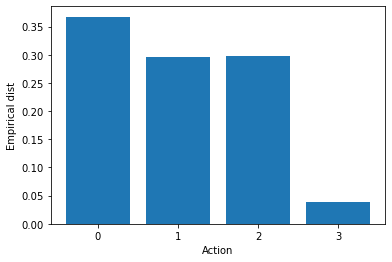

In [86]:
counts = np.bincount([trainer.compute_single_action(0) for _ in range(10_000)])
plt.bar([0,1,2,3], counts/10_000)
plt.xticks([0,1,2,3]);
plt.xlabel("Action");
plt.ylabel("Empirical dist");

#### Acting deterministically

We can also tell the agent to act deterministically with `explore=False`:

In [87]:
ppo.compute_single_action(0, explore=False)

0

In [92]:
print([ppo.compute_single_action(0, explore=False) for _ in range(100)])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Often this is desirable, but **sometimes the optimal policy is stochastic**.

Notes:

During training, exploration is a fundamental concept in RL. We will discuss it in Module 4!

In Module 4 we'll also see an example where the optimal policy is stochastic, so we would definitely not want to set `explore=False` in deployment.

#### Let's apply what we learned!

## RLlib config syntax
<!-- multiple choice -->

Which of the following is **NOT** correct RLlib syntax for instantiating a PPO algorithm instance? Assume the import

```python
from ray.rllib.algorithms.ppo import PPO, PPOConfig
```

has already been run.

- [ ] PPOConfig().build(env="FrozenLake-v1")
- [ ] PPOConfig().environment(env="FrozenLake-v1").build()
- [x] PPOConfig(env="FrozenLake-v1").build()
- [ ] PPO(env="FrozenLake-v1")

In [27]:
# # HIDDEN
# from ray.rllib.algorithms.ppo import PPO, PPOConfig

# PPOConfig().framework("torch").build(env="FrozenLake-v1")
# PPOConfig().framework("torch").environment(env="FrozenLake-v1").build()
# PPO(env="FrozenLake-v1", config={"framework" : "torch"})
# PPOConfig(env="FrozenLake-v1").framework("torch").build()

## Saving/restoring omdels
<!-- multiple choice -->

Which of the following is **NOT** a relevant use of saving ("checkpointing") models in RLlib?

- [x] Checkpointing generates cryptocurrency.
- [ ] In a course like this, loading a checkpoint means you don't always have to wait for models to train.
- [ ] Saved models can be stored, shared, copied and/or moved for deployment.
- [ ] Training can be resumed from a checkpoint in case it fails and needs to be restarted.

exercise: draw the max prob of the plicy as a measure of sureness

## Visualizing the policy
<!-- coding exercise -->

In the slides we looked at the probability of

could revisit previs Ex but look at probabilities this time

## Cartpole environment
<!-- coding exercise -->

A famous benchmark environment in RL is the _Cartpole_ environment, in which the agent must balance an [inverted pendulum](https://en.wikipedia.org/wiki/Inverted_pendulum) by applying force on the cart (at the bottom) to keep it stable. More information is available in the gym documentation [here](https://www.gymlibrary.ml/environments/classic_control/cart_pole/).

Note: the code below imports the env `MyCartPole`. This is identical to gym's `'CartPole-v1'` except that the rendering method has been overridden with something that can be displayed inside of this interactive course platform. 

In [1]:
# SOLUTION
import numpy as np
import time
from IPython import display

from envs import MyCartPole
from ray.rllib.algorithms.ppo import PPO, PPOConfig

config = (
    PPOConfig()\
    .framework("torch")\
    .rollouts(create_env_on_local_worker=True)\
    .debugging(seed=0, log_level="ERROR")\
    .training(model={"fcnet_hiddens" : [32,32]})
)

ppo = config.build(env=MyCartPole);

In [2]:
rewards = []
for i in range(50):
    out = ppo.train()
    rewards.append(out["episode_reward_mean"])

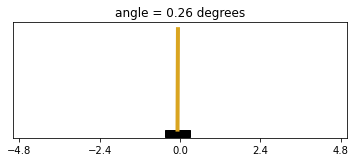

In [4]:
env = MyCartPole()
obs = env.reset()

for i in range(20):
    
    action = ppo.compute_single_action(obs)
    
    obs, reward, done, _ = env.step(action)

    env.render()
    time.sleep(0.2)

display.clear_output(wait=True);

# make a plot of prob(push left) vs. angle??

# TODO

need to be able to load a trained model here, which is currently not working. then, split this up into 2 coding exercises, one with the video and one with the plot.

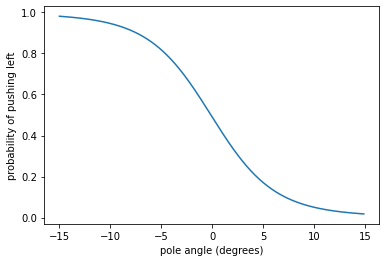

In [12]:
from utils import query_policy
import numpy as np
import matplotlib.pyplot as plt

angle_range_deg = np.arange(-15,15,0.1)
push_left_probs = 0*angle_range_deg

for i, angle_deg in enumerate(angle_range_deg):
    angle_rad = angle_deg/180*np.pi
    
    obs = np.zeros(4)
    obs[2] = angle_rad

    push_left_probs[i] = query_policy(ppo, env, obs, actions=[0,1])[0]

plt.plot(angle_range_deg, push_left_probs);
plt.xlabel("pole angle (degrees)")
plt.ylabel("probability of pushing left");

#### Interpreting the plot

How does the observed pole angle affect the trained agent's probability of pushing left?

- [ ] Positive pole angles (leaning right) result in the agent pushing the cart left. | The agent wants to push the cart underneath the top of the pole.
- [x] Negative pole angles (leaning left) result in the agent pushing the cart left.
- [ ] The agent's probability of pushing left is not significantly affected by the pole angle.
- [ ] None of the above.